## Solving $A\lvert x \rangle = \lvert b \rangle$ using QSVT

Let's define a toy problem we would implement in Qiskit. We consider solving $A\lvert x \rangle = \lvert b \rangle$ where

$$A = c_0 A_0 + c_1 A_1$$ where $A_0 = X \otimes X,$  
$A_1 = Z \otimes Z$ and $c_0, c_1 \ge 0$. Also,


$$ \lvert b \rangle = H^{\otimes 2} \lvert 00 \rangle$$. We also strictly enforce that A is a Hemitian matrix.

### Block-encoding of A

We introduce $\zeta$, so that 
$cos(\zeta) = \frac{\sqrt{c_0}}{\sqrt{c_0 + c_1}}$ and $sin(\zeta) = \frac{\sqrt{c_1}}{\sqrt{c_0 + c_1}}$. 
The circuit shown below can block-encode A. 

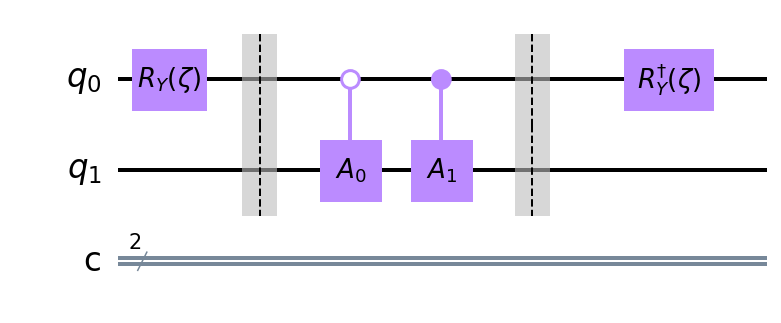

In [2]:
from qiskit.aqua.algorithms import NumPyMinimumEigensolver
from qiskit.optimization.algorithms import GroverOptimizer, MinimumEigenOptimizer, GroverOptimizationResult
from qiskit.optimization.problems import QuadraticProgram
from docplex.mp.model import Model
from qiskit.circuit.library import QuadraticForm
from qiskit.aqua.algorithms.amplitude_amplifiers.grover import Grover
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit import IBMQ, BasicAer ,Aer
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.optimization.converters.quadratic_program_to_qubo import (QuadraticProgramToQubo,
                                                    QuadraticProgramConverter)
from qiskit.optimization.algorithms import (OptimizationResultStatus, OptimizationAlgorithm,
                                     OptimizationResult)
import math as math
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Union, List
from copy import deepcopy
from qiskit.circuit import ParameterVector, Parameter
from collections import defaultdict
from scipy.optimize import minimize
from qiskit.quantum_info.states import partial_trace
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp



def named_circ(name, control=True):
    qc1 = QuantumCircuit(1, name=name)
    qc1.x(0) #dummy gate
    if control:
        named_circ = qc1.to_gate().control(1, ctrl_state='1')
    else:
        named_circ = qc1.to_gate()
    
    return named_circ

def rev_named_circ(name, control=True):
    qc1 = QuantumCircuit(1, name=name)
    qc1.x(0) #dummy gate
    if control:
        named_circ = qc1.to_gate().control(1, ctrl_state='0')
    else:
        named_circ = qc1.to_gate()
    
    return named_circ

qc2 = QuantumCircuit(QuantumRegister(2, 'q'), ClassicalRegister(2, 'c'))
qc2.append(named_circ(r'$R_Y(\zeta)$', control=False), [0])
qc2.barrier()
qc2.append(rev_named_circ(r'$A_0$'), [0, 1])
qc2.append(named_circ(r'$A_1$'), [0, 1])
qc2.barrier()
qc2.append(named_circ(r'$R_Y^{\dagger}(\zeta)$', control=False), [0])
qc2.draw('mpl', scale=2.0)

Let's examine why such a circuit block-encodes A. The set of transformations we plan to do are

$$
\begin{aligned}
& |0\rangle |\psi\rangle \mapsto R_Y(\zeta) |0\rangle |\psi\rangle\ \\
& \mapsto \bigg(\cos(\zeta)|0\rangle + \sin(\zeta) |1\rangle\bigg) |\psi\rangle \\
& \mapsto  \cos(\zeta) |0\rangle A_{0} |\psi\rangle 
+ \sin(\zeta) |1\rangle A_{1} |\psi\rangle  \\
& \mapsto |0 \rangle \frac{1}{c_0 + c_1} \big( c_0 A_{0} + c_1 A_{1} \big) |\psi\rangle 
- |1\rangle \frac{\sqrt{c_0 c_1}} {c_0 + c_1} \big(A_{0} - A_{1} \big) |\psi\rangle \\
& = |0 \rangle \alpha A |\psi\rangle 
- |1\rangle \beta W |\psi\rangle 
\end{aligned}
$$

where $R_Y(\zeta) = e^{-i \zeta Y}$ and Y denotes Pauli-Y gate. In the last equation, we have replaced 
$\alpha = \frac{1}{c_0 + c_1}$, $\beta = \frac{\sqrt{c_0 c_1}} {c_0 + c_1}$, and $W = \big(A_{0} - A_{1} \big)$. We can further 
write the last equation as

$$
\begin{aligned}
& |0 \rangle \otimes \alpha A |\psi\rangle 
- |1\rangle \otimes \beta W |\psi\rangle \\
=& \big(I \otimes \alpha A - X \otimes \beta W \big)|0 \rangle \otimes |\psi\rangle
\end{aligned}
$$

Hence the unitary $U$ that block encodes $A$ is $U = Z \otimes \alpha A - X \otimes \beta W = \begin{bmatrix}
\alpha A & -\beta W \\
-\beta W & -\alpha A
\end{bmatrix}$. We can write, $A = \Pi U \tilde{\Pi}$, where $\Pi = \tilde{\Pi} = \lvert 0 \rangle \langle 0 \rvert \otimes I$.

#### U circuit

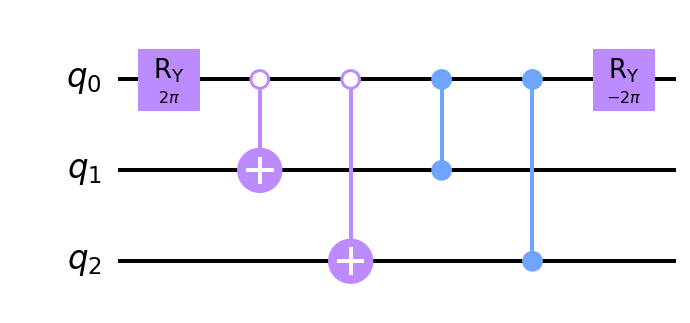

In [195]:
def U_circ(nqubits, theta):
    
    qc = QuantumCircuit(nqubits+1)
    
    qc.ry(2 * theta, 0)
    
    qc.cx(0, 1, ctrl_state='0')
    qc.cx(0, 2, ctrl_state='0')
    qc.cz(0, 1)
    qc.cz(0, 2)
    
    qc.ry(-2 * theta, 0)
    
    return qc

U_circ(2, np.pi).draw('mpl', scale=2.0)

#### $U_{chebv}$ circuit

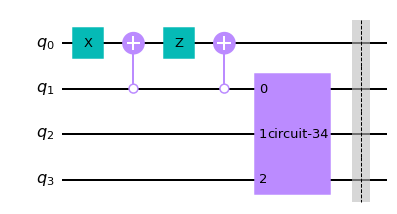

In [4]:
def U_chebv(nqubits, theta, k):
    
    """
    A circuit that implements Chebyshev polynomial of order k
    
    """
    
    qc = QuantumCircuit(nqubits+2)
    for i in range(0, k):
        qc.x(0)
        qc.cx(1, 0, ctrl_state='0')
        qc.z(0)
        qc.cx(1, 0, ctrl_state='0')
        
        #apply U
        qc.append(U_circ(nqubits, theta), [1]+list(range(2, 2+nqubits)))
        qc.barrier()
        
    return qc

U_chebv(2, np.pi/4, 1).draw('mpl')

In [14]:
def b_circuit(nqubits, topwire_one=False):
    
    qc = QuantumCircuit(nqubits)
        
    qc.h(0)
    qc.h(1)
    
    return qc  

b_circuit(2).draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

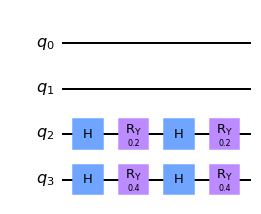

In [89]:
def param_unitary(parameter, nqubits=2, nshots=1024, reps=1):
    
    qc = QuantumCircuit(nqubits+2)
    
    qc.h(2)
    qc.h(3)
    
    qc.ry(2 * parameter[0], 2)
    qc.ry(2 * parameter[1], 3)
    
    qc.h(2)
    qc.h(3)
    
    qc.ry(2 * parameter[2], 2)
    qc.ry(2 * parameter[3], 3)
    
    
    return qc

param_unitary(2 * [0.1, 0.2]).draw('mpl')

In [160]:
Id = np.identity(2)
ket0 = np.array([1, 0])
ket1 = np.array([0, 1])
Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
c0 = 0.1
c1 = 0.1

# A matrix coefficient
init_cm = np.array([c0, c1])

# Conversion of the coefficient
norm = np.linalg.norm(init_cm, 1)

theta = np.arccos(np.sqrt(c0/(c0 + c1)))

A_0 = np.kron(X, X)

A_1 = np.kron(Z, Z)

A_num = c0 * A_0 + c1 * A_1

#we seek to solve Bx = b equation
b = np.ones(4)/2

B_num = np.kron(Id, Id) - A_num

B_inv = np.linalg.inv(B_num)

x_actual = B_inv.dot(b.reshape(len(b), 1))
x_actual = x_actual/np.linalg.norm(x_actual)
B_inv

array([[1.125     , 0.        , 0.        , 0.125     ],
       [0.        , 0.91666667, 0.08333333, 0.        ],
       [0.        , 0.08333333, 0.91666667, 0.        ],
       [0.125     , 0.        , 0.        , 1.125     ]])

In [68]:
def pauli_B_circuit(pauli):
    
    qc = QuantumCircuit(2)
    
    if pauli == 'II':
        pass
    elif pauli == 'XX':
        qc.x(0)
        qc.x(1)
    elif pauli == 'ZZ':
        qc.z(0)
        qc.z(1)
    else:
        pass
    
    return qc

def fidelity_circ():
    
    qc_g = QuantumCircuit(3)
    
    qc_g.h(1)
    qc_g.h(2)
    qc_g.x(1)
    qc_g.x(2)
    qc_g.mcx([1, 2], 0)
    qc_g.x(1)
    qc_g.x(2)
    qc_g.h(1)
    qc_g.h(2)
    
    qc_g = qc_g.to_gate().control(1)
    qc = QuantumCircuit(4)
    qc.append(qc_g, [3, 0, 1, 2])
    
    return qc

fidelity_circ().draw()

┌───────────────┐
q_0: ┤0              ├
     │               │
q_1: ┤1 circuit-1787 ├
     │               │
q_2: ┤2              ├
     └───────┬───────┘
q_3: ────────■────────

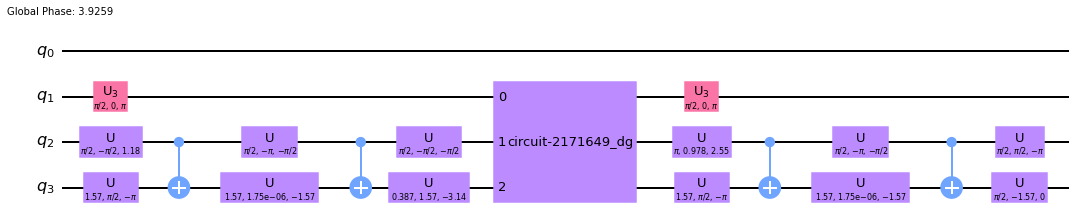

In [46]:
def get_dilated(D):
    
    "gets unitary version of D as descibed in the paper"
    plus_list = []
    minus_list = []
    
    for elem in D:
        plus_list.append(elem + 1.0j * np.sqrt(1/elem ** 2 - 1) * elem)
        minus_list.append(elem - 1.0j * np.sqrt(1/elem ** 2 - 1) * elem)
        
    Z = np.zeros((4,4),dtype=int) # Create off-diagonal zeros array
    dilated_D = np.asarray(np.bmat([[np.diag(plus_list), Z], 
                        [Z, np.diag(minus_list)]]))

    return dilated_D

def B_circuit(B_num, nqubits):
    
    #SVD 
    U, D, Vdag = np.linalg.svd(B_num)
    Uop = Operator(U)
    Vdag_op = Operator(Vdag)
    max_D = np.max(D)
    D = D/max_D #for the scheme to work we need all elements of D to be less than or equal to one, 
    #such a scaling would only affect the success probability

    dilated_D = get_dilated(D)

    qc = QuantumCircuit(nqubits+2)
    qc.append(Vdag_op, [2, 3])
    qc.h(1)
    qc.append(Operator(dilated_D), [1, 2, 3])
    qc.h(1)
    qc.append(Uop, [2, 3])
    
    return qc, max_D

B_circuit(B_num, nqubits=2)[0].decompose().decompose().draw('mpl')

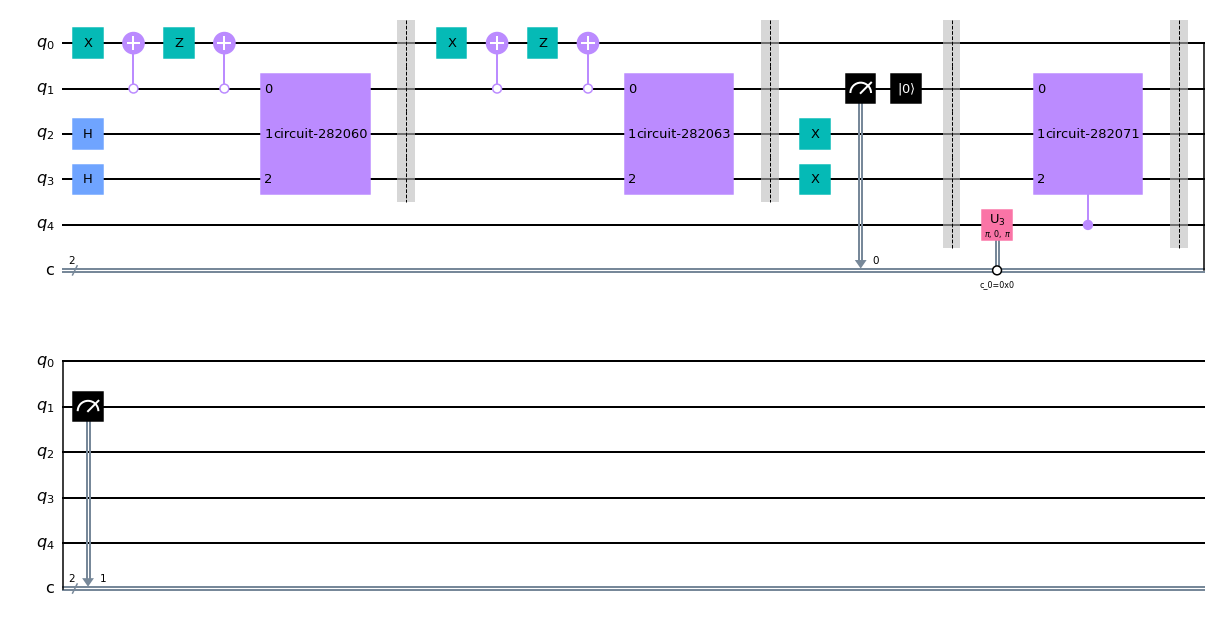

In [223]:
def composed_circuit(parameter, k, pauli, theta, nqubits=2):    
    

    qc = QuantumCircuit(nqubits+3, 2)

    qc.append(b_circuit(nqubits=2), [2, 3])
    qc.append(U_chebv(nqubits=2, theta=theta, k=k), [0, 1, 2, 3])
    #qc.append(U_circ(nqubits=2, theta=theta), [1, 2, 3])
    #qc.append(param_unitary(parameter), [0, 1, 2, 3])
    qc.append(pauli_B_circuit(pauli), [2, 3])
    qc.measure([1], [0])
    qc.reset(1)
    qc.barrier()
    qc.x(4).c_if(0, 0)
    #fidelity circuit
    qc.append(fidelity_circ(), [1, 2, 3, 4])
    qc.barrier()
    qc.measure([1], [1])
    return qc


composed_circuit(2 * [0.1, 0.2, 0.3], k=2, theta=theta, pauli='XX').decompose().draw('mpl')

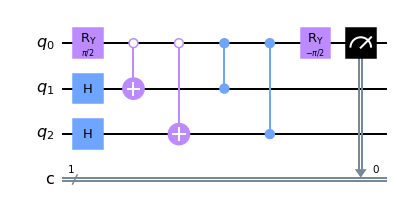

In [196]:
def ab_circuit(parameter, k, pauli, theta, nqubits=2):    
    

    qc = QuantumCircuit(nqubits+1, 1)

    qc.append(b_circuit(nqubits=2), [1, 2])
    qc.append(U_circ(nqubits=2, theta=theta), [0, 1, 2])
    
    qc.measure([0], [0])
    
    return qc

backend = Aer.get_backend('qasm_simulator', nshots=5000)
qc = ab_circuit(2 * [0.1, 0.2, 0.3], k=2, theta=theta, pauli='XX')
qc.decompose().draw('mpl')

In [213]:
counts = execute(qc, backend, nshots=10000).result().get_counts(qc)
print(counts['0']/(counts['0'] + counts['1']) * (c0 + c1) ** 2)
print((np.linalg.norm(A_num.dot(b)) ** 2))

0.020351562500000003
0.020000000000000007


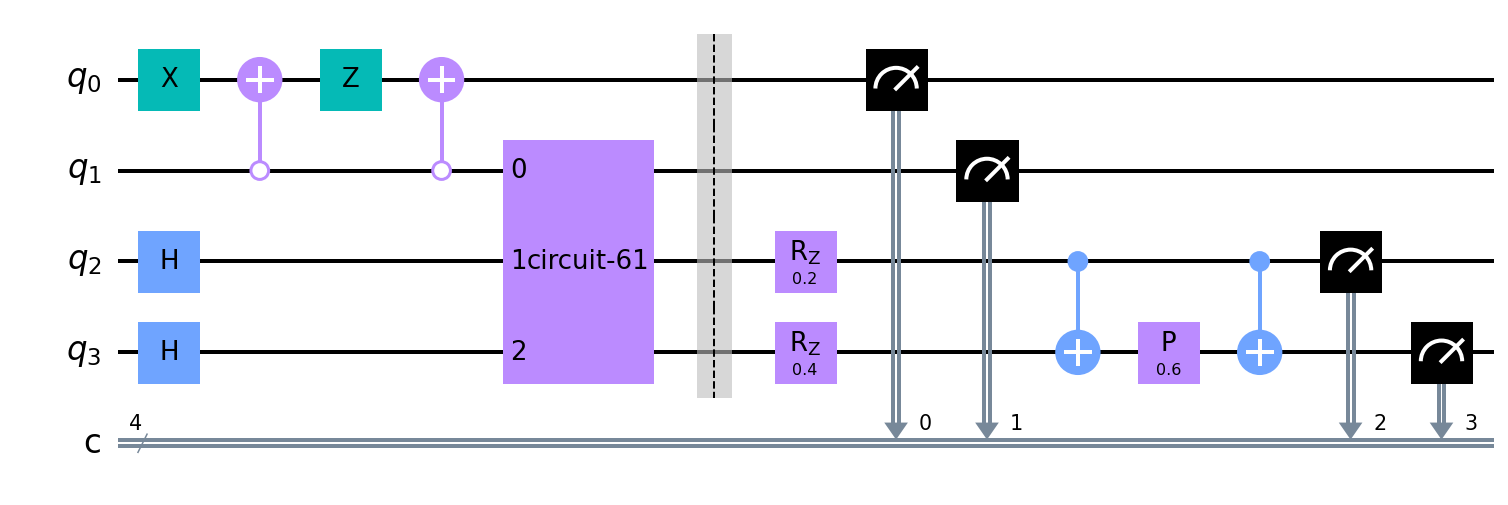

In [9]:
def norm_circuit(parameter, k, theta, nqubits=2):    
    
    alpha = 1/np.sqrt(c0 + c1)
    theta = np.arccos(np.sqrt(c0) * alpha)

    qc = QuantumCircuit(nqubits+2, nqubits+2)

    qc.append(b_circuit(nqubits=2), [0, 1, 2, 3])
    qc.append(U_chebv(nqubits=2, theta=theta, k=k), [0, 1, 2, 3])
    qc.append(param_unitary(parameter), [0, 1, 2, 3])
    qc.measure([0,1,2,3], [0,1,2,3])
    return qc


norm_circuit(2 * [0.1, 0.2, 0.3], k=1, theta=theta).decompose().draw('mpl', scale=2.0)

In [107]:
def x_calc(counts):
    
    p = {'00':0, '01':0, '10':0, '11':0}
    loc_count = 0
    tot_count = 0
    for state, count in counts.items():
        tot_count += count
        if state[2] == '0':
            p[state[0:2]] = count
            loc_count += count

    for key, val in p.items():
        p[key] = np.sqrt(p[key]/loc_count)

    x_calc = np.zeros(4)
    x_calc[0] = p['00']
    x_calc[1] = p['01']
    x_calc[2] = p['10']
    x_calc[3] = p['11']
    
    norm_x = np.sqrt(loc_count/tot_count)
    return x_calc, norm_x

def prob_zero(counts):
    
    p = {'0':0, '1':0}
    loc_count = 0
    tot_count = 0
    for state, count in counts.items():
        tot_count += count
        if state[1] == '0':
            p[state[0]] = count
            loc_count += count

    for key, val in p.items():
        p[key] = np.sqrt(p[key]/loc_count)

    x_calc = np.zeros(4)
    x_calc[0] = p['0']
    x_calc[1] = p['1']
    
    return x_calc

In [238]:
from qiskit import Aer, transpile

coeff_4 = [3/2, 7/4, 1/2, 1/4]
coeff_5 = [15/8, 7/4, 1, 1/4, 1/8]
coeff_6 = [15/8, 29/16, 1, 9/16, 1/8, 1/16]
r = c0 + c1

Bop = Operator(B_num)
pauli_op = SparsePauliOp.from_operator(Bop)


def fidelity(parameter, nshots=1024):
    
    fd = 0.0
    nrm = 0.0
    coeff = coeff_6
    for k in range(0, 6):
        for pauli in pauli_op.to_list():
            
            backend = Aer.get_backend('qasm_simulator')
            qc = composed_circuit(parameter, k=k, theta=theta, pauli=pauli[0])
            counts = execute(qc, backend, nshots=1024).result().get_counts(qc)
            print(counts)
            #qc_norm = norm_circuit(parameter, k=k, theta=theta)
            #counts_norm = execute(qc_norm, backend, nshots=1024).result().get_counts(qc_norm)
            fd += (r ** k) * coeff[k] * pauli[1] * prob_zero(counts)[1] 
            #fd += coeff[k] * prob_zero(counts)[1]
            #nrm += coeff[k] * pauli[1] * np.sqrt(prob_all_zero(counts_norm))
    
    print(fd)
    return fd

In [232]:
L = (coeff_4[0] * b.dot(B_num.dot(np.kron(Id, Id).dot(b))) + 1/((c0 + c1)) * coeff_4[1] * b.dot(B_num.dot(A_num.dot(b))) 
     + coeff_4[2] * 1/((c0 + c1) ** 2) * b.dot(B_num.dot(A_num.dot(A_num)).dot(b))) 
L

2.25

In [203]:
M = coeff_4[1] * b.dot(A_num.dot(b))
M

0.17500000000000002

In [239]:
#minimize(fidelity, x0= 2 * [0.1, 0.2], method="COBYLA")
fidelity(3 * [0.1, 0.5, 0.1]) 
#qc.decompose().draw('mpl')

{'10': 1024}
{'10': 1024}
{'00': 1024}
{'10': 249, '00': 269, '01': 506}
{'00': 258, '10': 225, '01': 541}
{'01': 515, '00': 256, '10': 253}
{'00': 1024}
{'00': 1024}
{'10': 1024}
{'10': 275, '00': 244, '01': 505}
{'00': 263, '10': 265, '01': 496}
{'10': 271, '00': 283, '01': 470}
{'10': 1024}
{'10': 1024}
{'00': 1024}
{'01': 486, '10': 252, '00': 286}
{'10': 237, '00': 253, '01': 534}
{'01': 512, '10': 246, '00': 266}
(1.887363673988564+0j)


(1.887363673988564+0j)

In [164]:
np.sqrt(0.75)

0.8660254037844386

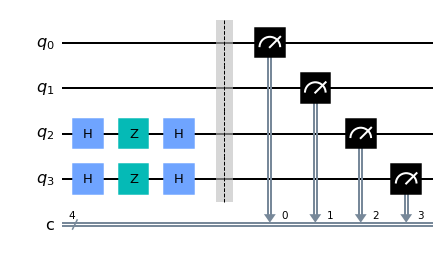

In [548]:
backend = Aer.get_backend('qasm_simulator')
list_pauli = pauli_op.to_list()
qc = composed_circuit(parameter[0:3], k=0, pauli=list_pauli[2][0])
qc.decompose().draw('mpl')

### Exact circuits

In [ ]:
def pauli_B_inv_circuit(pauli):
    
    qc = QuantumCircuit(2)
    
    if pauli == 'II':
        pass
    elif pauli == 'XX':
        qc.x(0)
        qc.x(1)
    elif pauli == 'YY':
        qc.y(0)
        qc.y(1)
    elif pauli == 'ZZ':
        qc.z(0)
        qc.z(1)
    else:
        pass
    
    return qc

def composed_circuit_inv(parameter, k, pauli, pauli_inv, c0=0.2, c1=0.1, nqubits=2):    
    
    alpha = 1/np.sqrt(c0 + c1)
    theta = np.cos(np.sqrt(c0) * alpha)

    qc = QuantumCircuit(nqubits+2, nqubits+2)

    #qc.append(b_circuit(nqubits=2), [0, 1, 2, 3])
    qc.append(pauli_B_inv_circuit(pauli_inv), [2, 3]) 
    #qc.append(param_unitary(parameter), [0, 1, 2, 3])
    qc.append(pauli_B_circuit(pauli), [2, 3])
    #qc.append(b_circuit(nqubits=2), [0, 1, 2, 3])
    qc.barrier()
    qc.measure([0,1,2,3], [0,1,2,3])
    return qc


Bop_inv = Operator(B_inv)
pauli_op_inv = SparsePauliOp.from_operator(Bop_inv)

composed_circuit_inv(2 * [0.1, 0.2, 0.3], k=2, pauli='XX', 
                     pauli_inv='ZZ').decompose().draw('mpl', scale=2.0)

def fidelity_inv(parameter, nshots=1024):
    
    fd = 0.0
    coeff = coeff_6
    #for k in range(0, 6):
    for pauli in pauli_op.to_list():
        for pauli_inv in pauli_op_inv.to_list():
            
            qc = composed_circuit_inv(parameter[0:3], k, pauli[0], pauli_inv[0])

            backend = Aer.get_backend('qasm_simulator')
            counts = execute(qc, backend, nshots=1024).result().get_counts(qc)

            fd += pauli_inv[1] * pauli[1] * np.sqrt(prob_all_zero(counts))
    
    print(fd)
    return -fd

## Neumann Series

In [352]:
A = np.array([[0.2, 0.1],[0.4, 0.5]])

#make it hermitian 
A = A + A.T
Anorm =  np.max(np.linalg.eigvals(A))
A = A/Anorm/2

print(A)

# we want norm of A < 1
print(np.linalg.eigvals(A))

#We want to solve Bx=b problem
bp = np.ones(2) / np.sqrt(2)

B_num = Id - A

x_sol = Id.dot(bp) 
for i in range(1, 8):
    x_sol += np.linalg.matrix_power(A, i).dot(bp)
    
x_sol

[[0.15587308 0.19484135]
 [0.19484135 0.3896827 ]]
[0.04555578 0.5       ]


array([1.18930547, 1.5329023 ])

In [135]:
x_actual = np.linalg.inv(B_num).dot(bp)
x_actual

array([1.19301501, 1.53945405])

In [42]:
Binv = np.kron(X, Z) + np.kron(Id, Id) + np.kron(Z, Z)

In [43]:
Bp = np.linalg.inv(Binv)

In [44]:
from qiskit.quantum_info import SparsePauliOp

Bp = Operator(Bp)
SparsePauliOp.from_operator(Bp)

SparsePauliOp(['II', 'XZ', 'ZZ'],
              coeffs=[-1.+0.j,  1.+0.j,  1.+0.j])

In [79]:
!pip install pyqsp

     |████████████████████████████████| 46 kB 2.7 MB/s eta 0:00:01
     |████████████████████████████████| 17.6 MB 25.5 MB/s eta 0:00:01
  Created wheel for pyqsp: filename=pyqsp-0.1.6-py3-none-any.whl size=45234 sha256=9141204b202750018850dcea15ca998925501788b285dcc77e141375ab71aafb
  Stored in directory: /Users/vaibhawkumar/Library/Caches/pip/wheels/92/39/5a/c902bc575568d8b31199e67001a8632180e18a5edabfbf1201
Successfully built pyqsp
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

qiskit-aqua 0.9.1 requires docplex==2.15.194; sys_platform == "darwin", but you'll have docplex 2.22.213 which is i

In [80]:
from pyqsp.angle_sequence import QuantumSignalProcessingPhases
ang_seq = QuantumSignalProcessingPhases([1, 1, 1], signal_operator="Wx")
print(ang_seq)

AngleFindingError: Polynomial must have definite parity: [0.9999  0.9999  0.99995]